In [88]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy as sp
import scipy.fftpack
import skimage as ski  
from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [139]:
# setting to make life easier
Temperature='Temperature'
kmeans='TemperatureKmeansScore'
fft='TemperatureFFTScore'
fftp='TemperatureFFTPScore'
spectral='TemperatureSpectralScore'
sal='SaliencyAnomalyScore'
gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansB='kmeansAnomalyB'
spectralA='spectralAnomaly'
fftA='fftAnomaly'
fftpA='fftpAnomaly'
salA='salAnomaly'
genA='genAnomaly'

kmeans_break=1.9
spectral_break = 2.8
fft_break = 100
sal_break = 100
gen_break = 30000



#### What will be shown

General approach is straightforward
* read raw data in
* transform it so that it is compatible to the Monitoring pipeline
* add yet another anomaly detector based on computer vision technology. The point here is to show how to run pipeline anomaly functions 'locally', an important concept for automated testing.
* simplify the dataframe - we have only one entity, no need for an entity index
* render input data and anomaly scores properly scaled

<br>

We start with Microsoft's anomaly test data found here
https://github.com/microsoft/anomalydetector/blob/master/samples/sample.csv

and then proceed to applying anomaly detection to real life pump data


<br>


#### Current inventory of anomaly detectors by type

This is the list of functions to apply


| Detector | ML Type | Type         | How does it work |
| ------- | ------------ | ------- | ---------------- |
| KMeans | Unsupervised | Proximity | Clusters data points in centroid buckets, small buckets are outliers, score is distance to closest other bucket |
| Generalized | Unsupervised | Linear Model | Covariance matrix over data point vectors serves to measure multi-dimensional deviation |
| FFT | Unsupervised | Linear Model | Run FFT before applying Generalized |
| Spectral | Unsupervised | Linear Model | Compute signal energy to reduce dimensions |
| Saliency | Unsupervised | Linear Model | Apply saliency transform (from computer vision |
| SimpleAnomaly | **Supervised** | Ensemble | Run Gradient boosting on training data, anomaly if prediction deviates from actual data |
| --- | **Supervised** | LSTM | Train a stacked LSTM, anomaly if prediction deviates from actual data |



In [90]:
# Run on the good pump first 
# Get stuff in
df_i = pd.read_csv('./AzureAnomalysample.csv', index_col=False, parse_dates=['timestamp'])

df_i['entity']='MyRoom'
df_i['Temperature']=df_i['value'] + 20
df_i = df_i.drop(columns=['value'])

# and sort it by timestamp
df_i = df_i.sort_values(by='timestamp')
df_i = df_i.set_index(['entity','timestamp']).dropna()

df_i.head(2)

Temperature
entity timestamp                       
MyRoom 2017-10-09 20:32:00         23.0
       2017-10-09 20:33:00         23.0

In [91]:
# Now run the anomaly functions as if they were executed in a pipeline

spsi = SpectralAnomalyScore(Temperature, 12, spectral)
et = spsi._build_entity_type(columns = [Column(Temperature,Float())])
spsi._entity_type = et
df_i = spsi.execute(df=df_i)

sali = SaliencybasedGeneralizedAnomalyScore(Temperature, 12, sal)
et = sali._build_entity_type(columns = [Column(Temperature,Float())])
sali._entity_type = et
df_i = sali.execute(df=df_i)

ffti = FFTbasedGeneralizedAnomalyScore(Temperature, 12, fft)
et = ffti._build_entity_type(columns = [Column(Temperature,Float())])
ffti._entity_type = et
df_i = ffti.execute(df=df_i)

kmi = KMeansAnomalyScore(Temperature, 12, kmeans)
et = kmi._build_entity_type(columns = [Column(Temperature,Float())])
kmi._entity_type = et
df_i = kmi.execute(df=df_i)

df_i.describe()

2020-02-15T12:35:31.889 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-02-15T12:35:31.891 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-02-15T12:35:32.013 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-02-15T12:35:32.014 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-02-15T12:35:33.028 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-02-15T12:35:33.029 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-02-15T12:35:34.088 WARNING iotfunctions.metadat

,Temperature,TemperatureSpectralScore,SaliencyAnomalyScore,TemperatureFFTScore,TemperatureKmeansScore
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,24.264336,0.844163,88.215978,87.253236,0.727266
std,1.484244,0.537002,554.991193,352.772404,1.103657
min,20.000000,0.000064,0.654624,-3.743968,-0.079926
25%,23.062500,0.424042,6.758017,7.943150,0.369826
50%,24.000000,0.787410,15.376792,12.750768,0.470409
75%,25.437500,1.218938,30.422623,18.868769,0.581440
max,30.750000,3.101990,11212.175303,4305.368335,7.550448


In [92]:
sali = SaliencybasedGeneralizedAnomalyScore(Temperature, 12, sal+'_')
et = sali._build_entity_type(columns = [Column(Temperature,Float())])
sali._entity_type = et
df_i = sali.execute(df=df_i)
comp = np.all(np.where(df_i[sal] != df_i[sal+'_'], True, False))
comp

2020-02-15T12:35:35.001 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-02-15T12:35:35.002 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


True

In [93]:
# Simplify our pandas dataframe to prepare input for plotting
EngineLogging.configure_console_logging(logging.INFO)

df_inputm2 = df_i.loc[['MyRoom']]
df_inputm2.reset_index(level=[0], inplace=True)

In [173]:
# dampen gradient and reconstruct anomaly function

dampening = 0.8 # gradient dampening
fftp_break = fft_break * dampening

# TODO error testing for arrays of size <= 1
fftgradN = np.gradient(df_inputm2[fft].values)
print (fftgradN)

fftgradS = np.float_power(abs(fftgradN), dampening) * np.sign(fftgradN)  # dampening

# reconstruct (dampened) anomaly score by discrete integration
fftlist = []
x = fftval[0] 
for xit in np.nditer(fftgradS):
    x = x + xit
    fftlist.append(x)

# shift array slightly to the right to position anomaly score
fftI = np.roll(np.asarray(fftlist), 1) 
fftI[0] = fftI[1]

# normalize
df_inputm2[fftp] = fftI / dampening / 2
df_inputm2.describe()

[ 1.01980879  1.01980879  1.01980879 ... -0.6826317  -0.6826317
 -0.6826317 ]


,Temperature,TemperatureSpectralScore,SaliencyAnomalyScore,TemperatureFFTScore,TemperatureKmeansScore,SaliencyAnomalyScore_,TemperatureFFTPScore,kmeansAnomaly,kmeansAnomalyB,fftAnomaly,fftpAnomaly,spectralAnomaly,salAnomaly
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,235.0,4000.000000,250.0,209.0,8.0,235.0
mean,24.264336,0.844163,88.215978,87.253236,0.727266,88.026372,2.445663,1.9,3.058750,100.0,80.0,2.8,100.0
std,1.484244,0.537002,554.991193,352.772404,1.103657,553.753590,67.785588,0.0,0.235186,0.0,0.0,0.0,0.0
min,20.000000,0.000064,0.654624,-3.743968,-0.079926,0.652600,-66.065149,1.9,3.000000,100.0,80.0,2.8,100.0
25%,23.062500,0.424042,6.758017,7.943150,0.369826,6.754162,-22.608713,1.9,3.000000,100.0,80.0,2.8,100.0
50%,24.000000,0.787410,15.376792,12.750768,0.470409,15.359533,-12.436910,1.9,3.000000,100.0,80.0,2.8,100.0
75%,25.437500,1.218938,30.422623,18.868769,0.581440,30.366544,6.356286,1.9,3.000000,100.0,80.0,2.8,100.0
max,30.750000,3.101990,11212.175303,4305.368335,7.550448,11140.953953,662.142304,1.9,4.000000,100.0,80.0,2.8,100.0


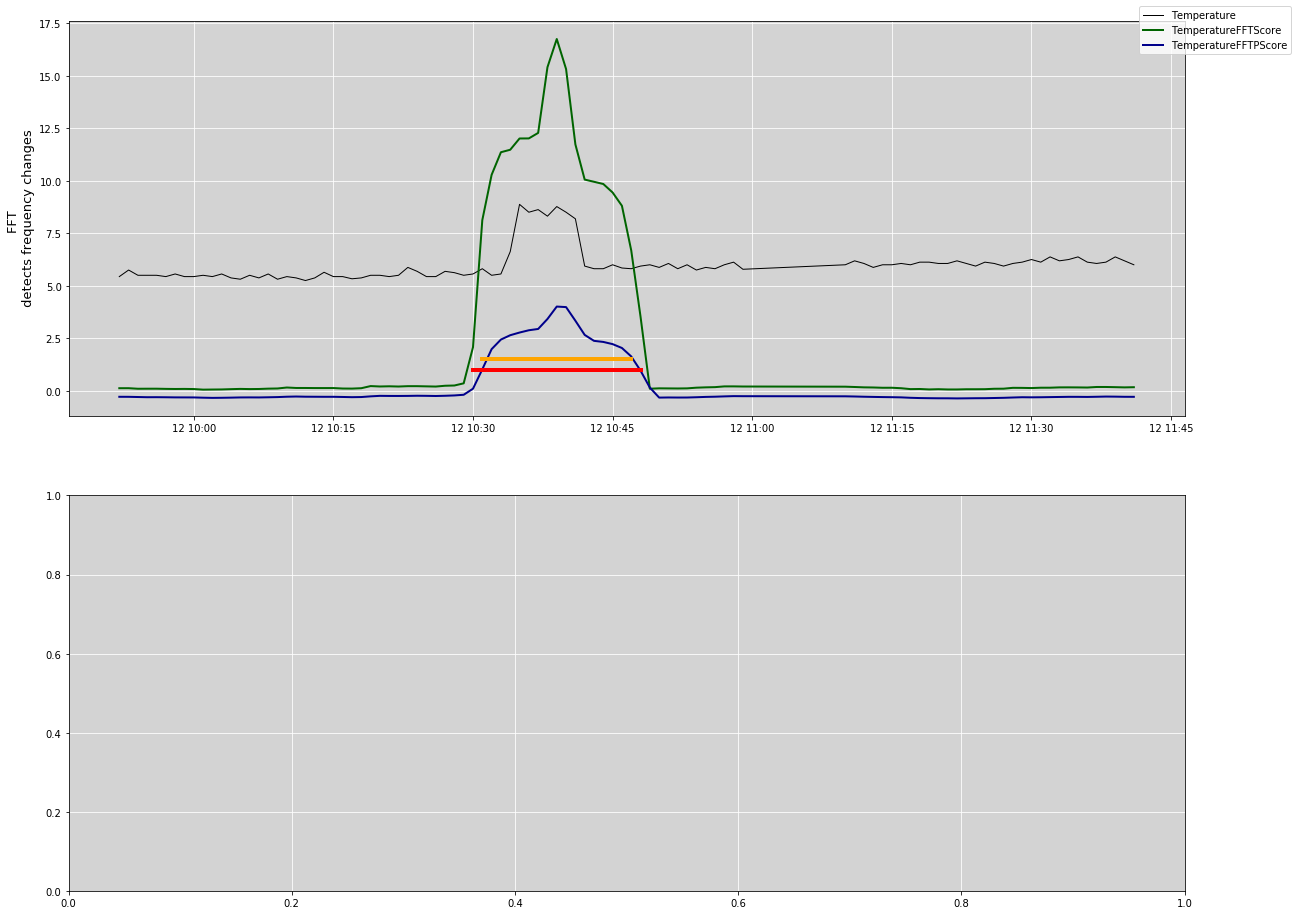

In [175]:
# df_inputm2[spectral].values[df_inputm2[spectral] > 0.001] = 0.001
# df_inputm2[fft].values[df_inputm2[fft] < -1] = -1
df_inputm2[kmeansA] = df_inputm2[kmeans]
df_inputm2[kmeansA].values[df_inputm2[kmeansA] < kmeans_break] = np.nan
df_inputm2[kmeansA].values[df_inputm2[kmeansA] > kmeans_break] = kmeans_break
df_inputm2[kmeansB] = df_inputm2[kmeans]
df_inputm2[kmeansB].values[df_inputm2[kmeansB] >= kmeans_break] = 4
df_inputm2[kmeansB].values[df_inputm2[kmeansB] < kmeans_break] = 3


df_inputm2[fftA] = df_inputm2[fft]
df_inputm2[fftA].values[df_inputm2[fftA] < fft_break] = np.nan
df_inputm2[fftA].values[df_inputm2[fftA] > fft_break] = fft_break
df_inputm2[fftpA] = df_inputm2[fftp]
#df_inputm2[fftp].values[df_inputm2[fft] > fftp_break] = fftp_break
df_inputm2[fftpA].values[df_inputm2[fftpA] < fftp_break] = np.nan
df_inputm2[fftpA].values[df_inputm2[fftpA] > fftp_break] = fftp_break
df_inputm2[spectralA] = df_inputm2[spectral]
df_inputm2[spectralA].values[df_inputm2[spectralA] < spectral_break] = np.nan
df_inputm2[spectralA].values[df_inputm2[spectralA] > spectral_break] = spectral_break
df_inputm2[salA] = df_inputm2[sal]
df_inputm2[salA].values[df_inputm2[salA] < sal_break] = np.nan
df_inputm2[salA].values[df_inputm2[salA] > sal_break] = sal_break
#df_inputm2[genA] = df_inputm2[gen]
#df_inputm2[genA].values[df_inputm2[genA] < gen_break] = np.nan
#df_inputm2[genA].values[df_inputm2[genA] > gen_break] = gen_break

plots = 2
x1=0
x2=4000
x1=3350
x2=3450
#x1 = 3550, x2 = 3650

fig, ax = plt.subplots(plots, 1, figsize=(20, 8 * plots))
cnt = 0
#ax[cnt].plot(df_inputm2.index[x1:x2], df_inputm2[Temperature][x1:x2]-20,linewidth=1,color='black',label=Temperature)
#ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
#ax[cnt].set_ylabel('Input Temperature - 20',fontsize=14,weight="bold")
cnt = 0
ax[cnt].plot(df_inputm2.index[x1:x2], df_inputm2[Temperature][x1:x2]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index[x1:x2], df_inputm2[fft][x1:x2]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_inputm2.index[x1:x2], df_inputm2[fftp][x1:x2]/fftp_break, linewidth=2,color='darkblue',label=fftp)
ax[cnt].plot(df_inputm2.index[x1:x2], df_inputm2[fftA][x1:x2]/fft_break, linewidth=4, color='red', zorder=2)
ax[cnt].plot(df_inputm2.index[x1:x2], df_inputm2[fftpA][x1:x2]/fftp_break + 0.5, linewidth=4, color='orange', zorder=2)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('FFT \n detects frequency changes', fontsize=13)

for i in range(plots):
    ax[i].grid(True, color='white')
    ax[i].set_facecolor('lightgrey')

#### Results

Clear **winners** are 
* **KMeans** and 
* **FFT**.

Spectral is way too sensitive while Saliency 
doesn't detect the negative peak at 10/10 midnight
